# Importing modules

In [2]:
# importing the modules necessary for the project
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

# Loading Data

In [3]:
# importing training, testing and validation data
training_data = "/DATA/chest_xray/train/"
testing_data = "/DATA/chest_xray/test/"
validation_data = "/DATA/chest_xray/val/"

In [4]:
# lassoing data for image previews
pneumonia = os.listdir("/DATA/chest_xray/train/PNEUMONIA")
pneumonia_data = "/DATA/chest_xray/train/PNEUMONIA"

In [5]:
# lassoing data for image previews
normal = os.listdir("/DATA/chest_xray/train/NORMAL")
normal_data = "/DATA/chest_xray/train/NORMAL"

# EDA

In [6]:
# gathering global data that are specific to the pneumonia and normal path directory
train_pneumonia = glob.glob(training_data+"/PNEUMONIA/*.jpeg")
train_normal = glob.glob(training_data+"/NORMAL/*.jpeg")

In [7]:
# concatenating the data for graph
data = pd.DataFrame(np.concatenate([[0]*len(train_normal) ,
                                    [1]*len(train_pneumonia)]),columns=["class"])

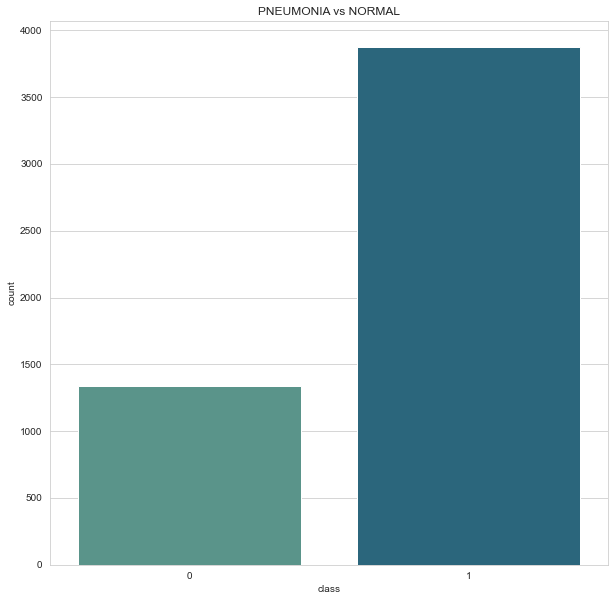

In [8]:
# graphing the data
plt.figure(figsize=(10,10))
sns.countplot(data['class'],data=data,palette='crest',color='blue')
plt.title('PNEUMONIA vs NORMAL')
plt.show()

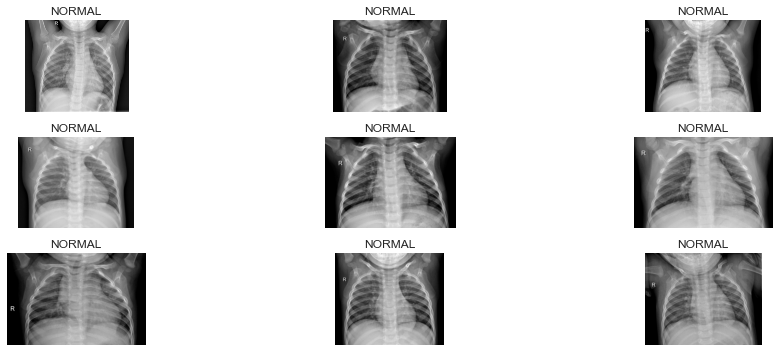

In [104]:
# plotting image previews for normal x-rays
plt.figure(figsize=(15, 5))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_data, normal[i]))
    plt.title("Normal")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

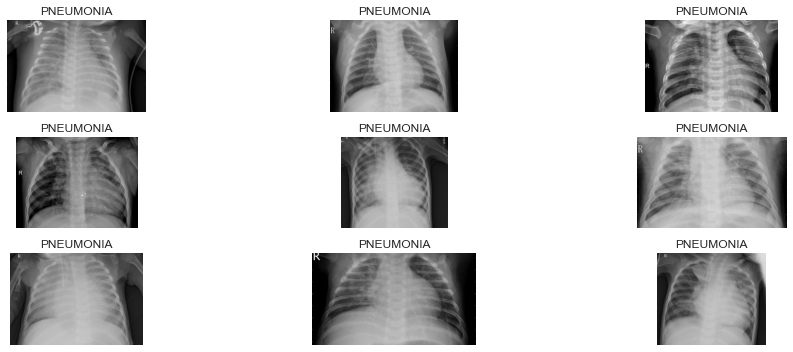

In [105]:
# plotting image previews for pneumonia x-rays
plt.figure(figsize=(15, 5))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_data, pneumonia[i]))
    plt.title("Pneumonia")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    

plt.tight_layout()

# Pre-processing - Data Augmentation

In [9]:
# data augmentation via ImageDataGenerator
image_data_generator = ImageDataGenerator(
        rescale = 1/255,
        shear_range=10,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5,2.0],
        width_shift_range = 0.2,
        rotation_range=20,
        fill_mode = 'nearest'
)
validation_data_generator = ImageDataGenerator(
        rescale = 1/255
)

In [10]:
train = image_data_generator.flow_from_directory(training_data,
                                       batch_size=64,
                                       class_mode='binary')

Found 5216 images belonging to 2 classes.


In [11]:
validation = validation_data_generator.flow_from_directory(validation_data,
                                              batch_size=64,
                                              class_mode='binary')

Found 16 images belonging to 2 classes.


In [12]:
test = validation_data_generator.flow_from_directory(testing_data,
                                       batch_size=64,
                                       class_mode='binary')

Found 624 images belonging to 2 classes.


# Creating the VGG19 Model

In [116]:
# Creating the VGG19 model
VGG19_model = tf.keras.applications.VGG19(
    weights='imagenet',
    include_top = False,
)

for layer in VGG19_model.layers:
    layer.trainable=False
    
x = VGG19_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)

predicting = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.Model(inputs=VGG19_model.input, outputs=predicting)

In [155]:
# setting early stopping and learning rate to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='Val_loss',patience=10)
learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor='Val_loss',patience=8)

In [118]:
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['Accuracy'])

In [53]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [56]:
# training the VGG19 model
history = model.fit(train,
                    epochs=30, 
                    validation_data=validation,
                    steps_per_epoch=50,
                    callbacks=[early_stopping,learning_rate],
                    batch_size=64)

Epoch 1/30
50/50 [==============================] - 138s 3s/step - loss: 0.5208 - accuracy: 0.7383 - val_loss: 0.5320 - val_accuracy: 0.7500
Epoch 2/30
50/50 [==============================] - 139s 3s/step - loss: 0.4513 - accuracy: 0.7859 - val_loss: 0.5238 - val_accuracy: 0.8125
Epoch 3/30
50/50 [==============================] - 138s 3s/step - loss: 0.4198 - accuracy: 0.8044 - val_loss: 0.5556 - val_accuracy: 0.6875
Epoch 4/30
50/50 [==============================] - 138s 3s/step - loss: 0.4085 - accuracy: 0.8062 - val_loss: 0.4765 - val_accuracy: 0.7500
Epoch 5/30
50/50 [==============================] - 141s 3s/step - loss: 0.3639 - accuracy: 0.8334 - val_loss: 0.4789 - val_accuracy: 0.7500
Epoch 6/30
50/50 [==============================] - 139s 3s/step - loss: 0.3668 - accuracy: 0.8303 - val_loss: 0.5121 - val_accuracy: 0.8125
Epoch 7/30
50/50 [==============================] - 137s 3s/step - loss: 0.3506 - accuracy: 0.8349 - val_loss: 0.4421 - val_accuracy: 0.8125
Epoch 8/30
50

In [61]:
# checking the loss and accuracy of model
model_score = model.evaluate(train)

print("Train Loss is: ", model_score[0])
print("Train Accuracy is: ", model_score[1])

82/82 [==============================] - 224s 3s/step - loss: 0.2405 - accuracy: 0.8997
Train Loss is:  0.24054977297782898
Train Accuracy is:  0.8997315764427185


In [62]:
model_score = model.evaluate(test)

print("Test Loss is: ", model_score[0])
print("Test Accuracy is: ", model_score[1])

10/10 [==============================] - 27s 3s/step - loss: 0.3320 - accuracy: 0.8542
Test Loss is:  0.33197253942489624
Test Accuracy is:  0.8541666865348816


# Plotting results

Text(0.5, 1.0, 'Accuracy')

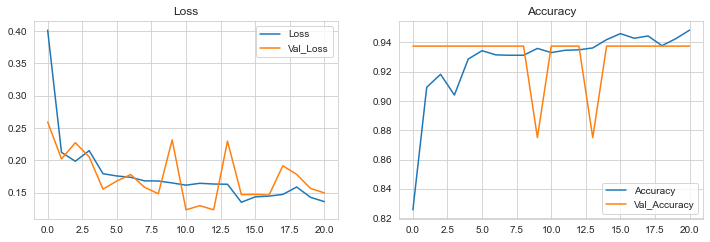

In [156]:
# plotting loss and accuracy graphs to visual representation of model performance
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['Loss'], label='Loss')
plt.plot(history.history['Val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss')

plt.subplot(2, 2, 2)
plt.plot(history.history['Accuracy'], label='Accuracy')
plt.plot(history.history['Val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy')

# Creating the ResNet Model

In [161]:
# Creating the ResNet50V2 model
ResNet50V2_model = tf.keras.applications.ResNet50V2(
    weights='imagenet',
    include_top = False,
    input_shape = (224,224,3)
)

for layer in ResNet50V2_model.layers:
    layer.trainable=False
    
x = ResNet50V2_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)

predicting = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model2 = tf.keras.Model(inputs=ResNet50V2_model.input, outputs=predicting)

In [162]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [164]:
model2.compile(loss='binary_crossentropy', optimizer='adam',metrics=['Accuracy'])

In [165]:
# training the ResNet50V2 model
history = model2.fit(train,
                    epochs=50, 
                    validation_data=validation,
                    steps_per_epoch=50,
                    callbacks=[early_stopping,learning_rate],
                    batch_size=32)

Epoch 1/50
50/50 [==============================] - 73s 1s/step - loss: 0.2849 - accuracy: 0.8741 - val_loss: 0.2009 - val_accuracy: 0.8750
Epoch 2/50
50/50 [==============================] - 73s 1s/step - loss: 0.2095 - accuracy: 0.9097 - val_loss: 0.3819 - val_accuracy: 0.8750
Epoch 3/50
50/50 [==============================] - 72s 1s/step - loss: 0.1951 - accuracy: 0.9217 - val_loss: 0.1624 - val_accuracy: 0.9375
Epoch 4/50
50/50 [==============================] - 72s 1s/step - loss: 0.1745 - accuracy: 0.9277 - val_loss: 0.1848 - val_accuracy: 0.9375
Epoch 5/50
50/50 [==============================] - 73s 1s/step - loss: 0.1736 - accuracy: 0.9312 - val_loss: 0.3631 - val_accuracy: 0.8125
Epoch 6/50
50/50 [==============================] - 72s 1s/step - loss: 0.1630 - accuracy: 0.9372 - val_loss: 0.2061 - val_accuracy: 0.9375
Epoch 7/50
50/50 [==============================] - 71s 1s/step - loss: 0.1625 - accuracy: 0.9359 - val_loss: 0.2672 - val_accuracy: 0.8750
Epoch 8/50
50/50 [==

In [167]:
# checking the loss and accuracy of model
model_score = model2.evaluate(train)
print("Train Loss: ", model_score[0])
print("Train Accuracy: ", model_score[1])

82/82 [==============================] - 123s 2s/step - loss: 0.1435 - accuracy: 0.9444
Train Loss:  0.14351990818977356
Train Accuracy:  0.9444018602371216


In [168]:
model_score = model2.evaluate(test)
print("\nTest loss: ", model_score[0])
print("Test Accuracy: ", model_score[1])

10/10 [==============================] - 11s 1s/step - loss: 0.1994 - accuracy: 0.9199

Test loss:  0.19943587481975555
Test Accuracy:  0.9198718070983887


# Plotting results

Text(0.5, 1.0, 'Accuracy')

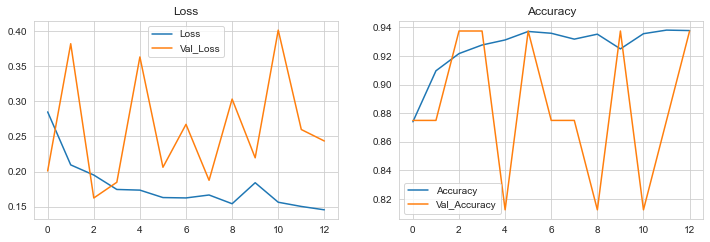

In [172]:
# plotting loss and accuracy graphs to visual representation of model performance
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['Loss'], label='Loss')
plt.plot(history.history['Val_loss'], label='Val_loss')
plt.legend()
plt.title('Loss')

plt.subplot(2, 2, 2)
plt.plot(history.history['Accuracy'], label='Accuracy')
plt.plot(history.history['Val_Accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy')